In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.models import Sequential
from keras import layers, optimizers
from keras.preprocessing.image import ImageDataGenerator

from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from joblib import dump, load

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Dataset

In [3]:
labels = os.listdir('fruits-360/Training')
labels.sort()
print('Il dataset contiene %i classi di frutta: ' %(len(labels)))
print(labels)

Il dataset contiene 131 classi di frutta: 
['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber Ripe', 'Cucumber Ripe 2', 'Dates', 'Eggplant', 'Fig', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 

### Load and split the dataset into Training (80%) and Validation (20%) dataset

In [28]:
batch_size = 512

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    validation_split = 0.2,
)

train = train_datagen.flow_from_directory(
    'fruits-360/Training',
    target_size=(100, 100),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = True,
    subset = 'training',
    seed = 42,
)

validation = train_datagen.flow_from_directory(
    'fruits-360/Training',
    target_size=(100, 100),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = True,
    subset = 'validation',
    seed = 42,
)

Found 54190 images belonging to 131 classes.
Found 13502 images belonging to 131 classes.


### Load the Test dataset

In [29]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
)

test = train_datagen.flow_from_directory(
    'fruits-360/Test',
    target_size=(64, 64),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
)

Found 22688 images belonging to 131 classes.


### Some fruits exaple

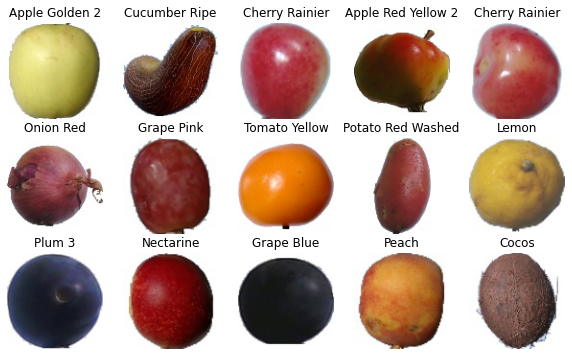

In [30]:
plot_x, plot_y = next(train)
train.reset()
_ , axs = plt.subplots(3,5, figsize = (10,6))
for i, ax in enumerate(axs.ravel()):
    index = np.random.randint(0, plot_x.shape[0])
    ax.imshow(plot_x[index])
    ax.set_title(labels[np.argmax(plot_y[index])])
    ax.axis('off')

# Convolutional Neural Network

In [7]:
model = Sequential()
model.add(layers.Input(shape = (64,64,3)))

model.add(layers.Conv2D(8, 3, activation = 'relu', padding = 'same'))
model.add(layers.MaxPooling2D(2))

model.add(layers.Conv2D(16, 3, activation = 'relu', padding = 'same'))
model.add(layers.MaxPooling2D(2))

model.add(layers.Conv2D(16, 3, activation = 'relu', padding = 'same'))
model.add(layers.MaxPooling2D(2))

model.add(layers.Flatten())
model.add(layers.Dense(131, activation = "softmax"))

model.compile(optimizer = optimizers.Adam(learning_rate=0.0001), loss = tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 8)         224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 16)        2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0

In [8]:
history = model.fit(
    train,
    epochs = 20,
    validation_data = validation,
    steps_per_epoch = len(train),
    validation_steps = len(validation)
)

Epoch 1/20
106/106 [==============================] - 22s 212ms/step - loss: 4.7857 - accuracy: 0.0262 - val_loss: 4.5690 - val_accuracy: 0.0534
Epoch 2/20
106/106 [==============================] - 18s 174ms/step - loss: 3.8679 - accuracy: 0.1848 - val_loss: 3.0965 - val_accuracy: 0.3531
Epoch 3/20
106/106 [==============================] - 19s 175ms/step - loss: 2.2246 - accuracy: 0.5132 - val_loss: 1.9462 - val_accuracy: 0.5638
Epoch 4/20
106/106 [==============================] - 18s 173ms/step - loss: 1.3304 - accuracy: 0.6869 - val_loss: 1.4361 - val_accuracy: 0.6535
Epoch 5/20
106/106 [==============================] - 18s 173ms/step - loss: 0.9293 - accuracy: 0.7783 - val_loss: 1.1921 - val_accuracy: 0.6983
Epoch 6/20
106/106 [==============================] - 19s 175ms/step - loss: 0.7010 - accuracy: 0.8319 - val_loss: 1.0606 - val_accuracy: 0.7233
Epoch 7/20
106/106 [==============================] - 18s 174ms/step - loss: 0.5523 - accuracy: 0.8673 - val_loss: 0.9850 - val_ac

### Visualize the loss function and the accuracy through the training

In [9]:
print('Informations stored in hystory:')
for key in history.history.keys():
    print(key)

Informations stored in hystory:
loss
accuracy
val_loss
val_accuracy


Text(0.5, 1.0, 'Loss')

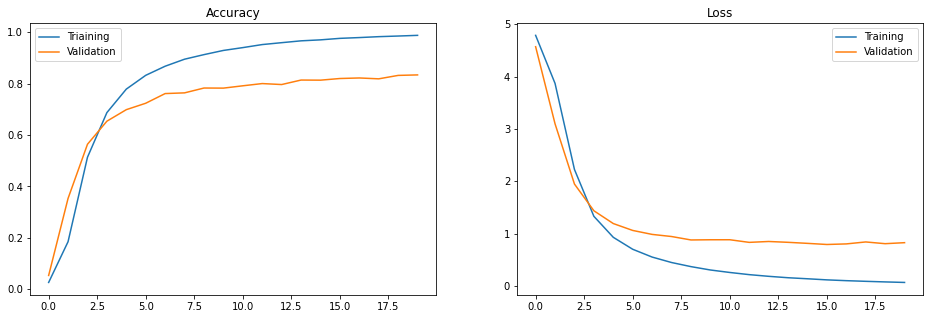

In [10]:
_ , ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(history.history['accuracy'], label = 'Triaining')
ax[0].plot(history.history['val_accuracy'], label = 'Validation')
ax[0].legend()
ax[0].set_title('Accuracy')

ax[1].plot(history.history['loss'], label = 'Training')
ax[1].plot(history.history['val_loss'], label = 'Validation')
ax[1].legend()
ax[1].set_title('Loss')

### Evaluate the model on the Test Dataset

In [11]:
score = model.evaluate(test, steps = len(test))

45/45 [==============================] - 8s 171ms/step - loss: 0.8515 - accuracy: 0.8137


In [12]:
print('**********************************************')
print('* Acurracy of the model = %s *' %(score[1]))
print('**********************************************')

**********************************************
* Acurracy of the model = 0.8137341141700745 *
**********************************************


# PCA and Decision Tree

In [31]:
number_of_images = 40000
number_of_test = 3000
risoluzione = 32

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
)

train = train_datagen.flow_from_directory(
    'fruits-360/Training',
    target_size=(risoluzione, risoluzione),
    color_mode='rgb',
    batch_size=number_of_images,
    class_mode='categorical',
    shuffle = True,
    seed = 42,
)

test = train_datagen.flow_from_directory(
    'fruits-360/Test',
    target_size=(risoluzione, risoluzione),
    color_mode='rgb',
    batch_size=number_of_test,
    class_mode='categorical',
    shuffle = True,
    seed = 42,
)

Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [32]:
x , y = next(train)
x_test, y_test = next(test)
print(x.shape)
print(x_test.shape)

(40000, 32, 32, 3)
(3000, 32, 32, 3)


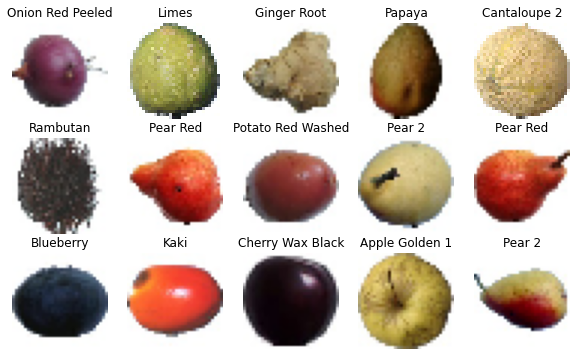

In [33]:
_ , axs = plt.subplots(3,5, figsize = (10,6))
for i, ax in enumerate(axs.ravel()):
    index = np.random.randint(0, x.shape[0])
    ax.imshow(x[index])
    ax.set_title(labels[np.argmax(y[index])])
    ax.axis('off')

Text(0.5, 1.0, 'Test')

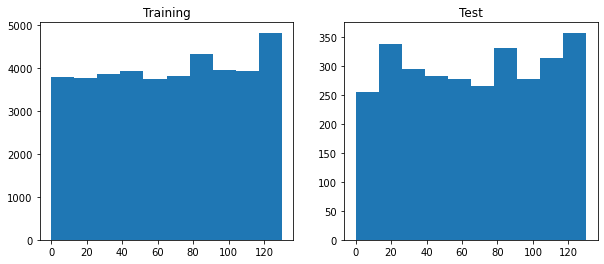

In [34]:
_, axs = plt.subplots(1,2, figsize = (10,4))
axs[0].hist(np.argmax(y, axis = 1))
axs[0].set_title('Training')
axs[1].hist(np.argmax(y_test, axis = 1))
axs[1].set_title('Test')

### Dimension reduction using PCA

In [35]:
scaler = StandardScaler()
x = scaler.fit_transform([i.flatten() for i in x])
x.shape

(40000, 3072)

In [36]:
#Costoso computazionalmente, caricare direttamente il modello già salvato.
#pca = PCA(n_components = 0.95)
#pca = pca.fit(x_scaled)
#dump(pca, 'pca.joblib')
pca = load('pca.joblib')

In [37]:
x_reduced = pca.transform(x)
print(x_reduced.shape)

(40000, 313)


In [38]:
scaler = StandardScaler()
x_test = scaler.fit_transform([i.flatten() for i in x_test])
x_test.shape
x_test = pca.transform(x_test)

### Decision Tree

In [39]:
#Molto lungo da eseguire, togliere il commento solo se si vuole refittare il modello, altrimenti fare load di quello già salvato
classifier = tree.DecisionTreeClassifier()
classifier = classifier.fit(x_reduced, y)
#dump(classifier, 'decision_tree.joblib')

### Test the accuracy

In [40]:
#classifier = load('decision_tree.joblib')

In [41]:
print('Training accuracy: %f' %(accuracy_score(y, classifier.predict(x_reduced))))
print('Test accuracy: %f' %(accuracy_score(y_test, classifier.predict(x_test))))

Training accuracy: 1.000000
Test accuracy: 0.622333


# Random Forest

In [42]:
rnd_forest = RandomForestClassifier(
    n_estimators = 100,
    max_depth = 25,
    criterion = 'gini',
    bootstrap = True,
    n_jobs = -1,
    )
rnd_forest = rnd_forest.fit(x_reduced, y)

In [43]:
print('Training accuracy: %f' %(accuracy_score(y, rnd_forest.predict(x_reduced))))
print('Test accuracy: %f' %(accuracy_score(y_test, rnd_forest.predict(x_test))))

Training accuracy: 0.979175
Test accuracy: 0.312000


In [44]:
from sklearn.model_selection import RandomizedSearchCV

In [45]:
#implementare una randomized search cv